In [1]:
import math as math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)


import warnings
warnings.filterwarnings('ignore')

In [3]:
import route_dynamics.route_energy.accel as ca
import route_dynamics.route_elevation.base_df as base

In [4]:
a_prof = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])

In [5]:
data=a_prof

In [6]:
data['time (s)'] = data['time (s)'].round(0)
data['accel. (g)'] = data['accel. (g)'].round(4)

In [7]:
#Convert to SI units
data['accel. (m/s^2)'] = data['accel. (g)']*9.81

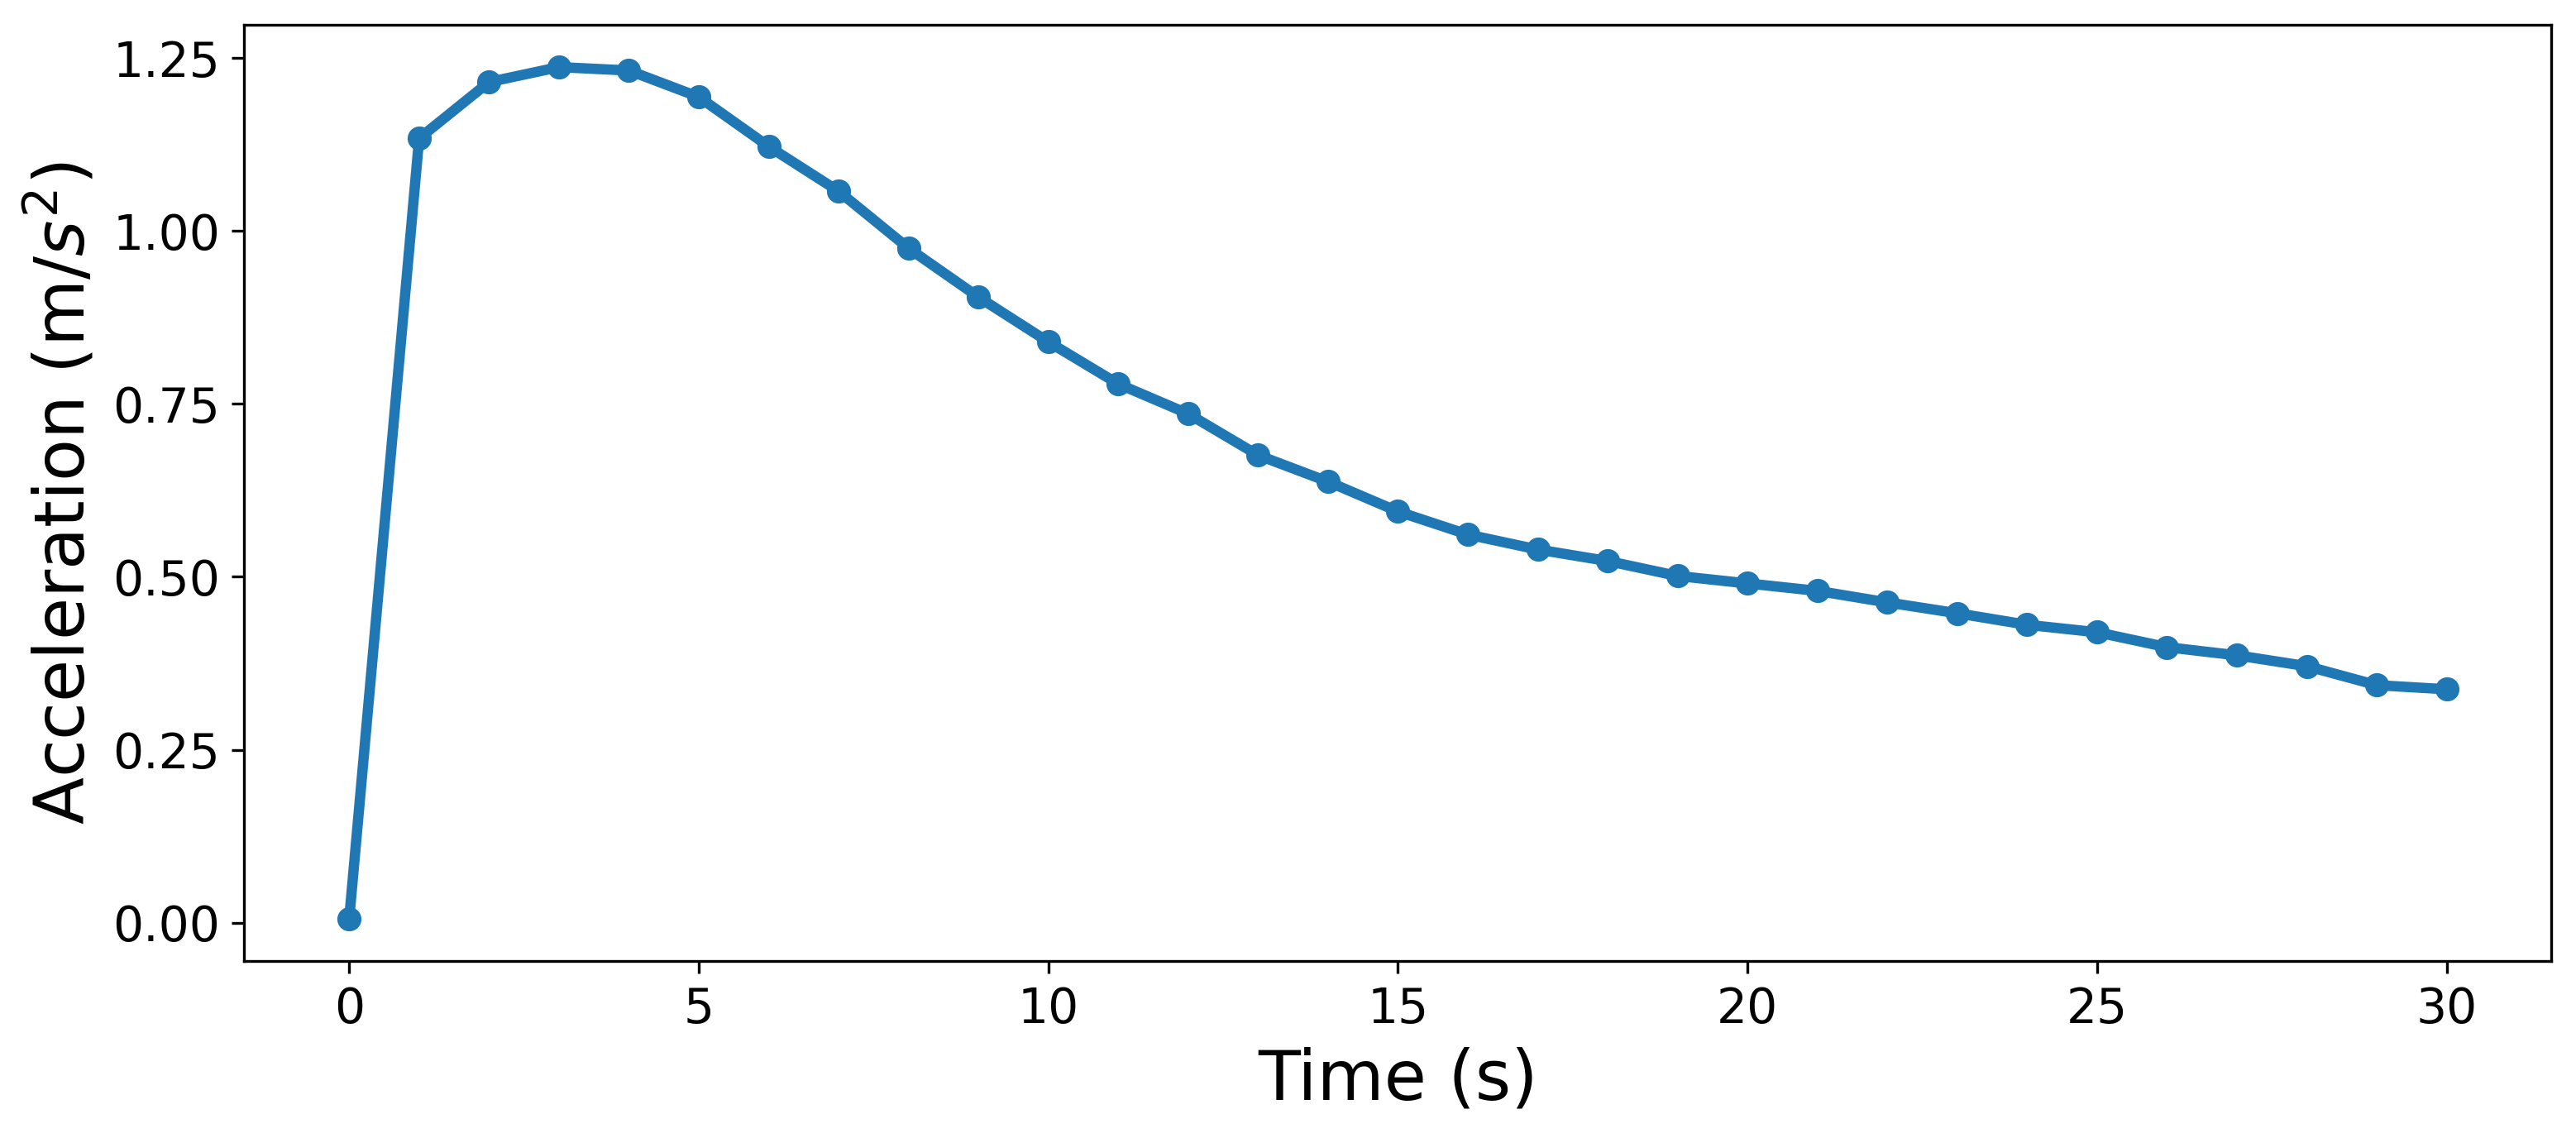

In [8]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(data['time (s)'], data['accel. (m/s^2)'], linewidth=3, marker='o')
ax.set_ylabel('Acceleration (m/$s^2$)', fontsize=20)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14) 

plt.rcParams["axes.linewidth"] = 1

plt.savefig('4_29/accel_vs_time.png', dpi=300)

In [9]:
#Calculate Velocity

data['vel. (m/s)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['vel. (m/s)'][i] = ((data['accel. (m/s^2)'][i] + data['accel. (m/s^2)'][i-1])/2*1) + data['vel. (m/s)'][i-1]
    
data['vel. (mph)'] = data['vel. (m/s)']*2.2

In [10]:
#Calculate Distance

data['dist. (m)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['dist. (m)'][i] = ((data['vel. (m/s)'][i] + data['vel. (m/s)'][i-1])/2*1) + data['dist. (m)'][i-1]

In [11]:
data['dist (km)'] = data['dist. (m)']/1000
data['dist (ft)'] = data['dist. (m)']*3.28
data.head()

,time (s),accel. (g),accel. (m/s^2),vel. (m/s),vel. (mph),dist. (m),dist (km),dist (ft)
0,0.0,0.0006,0.005886,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.1156,1.134036,0.569961,1.253914,0.284981,0.000285,0.934736
2,2.0,0.1239,1.215459,1.744709,3.838359,1.442315,0.001442,4.730794
3,3.0,0.1261,1.237041,2.970959,6.536109,3.800149,0.003800,12.464488
4,4.0,0.1256,1.232136,4.205547,9.252203,7.388402,0.007388,24.233957


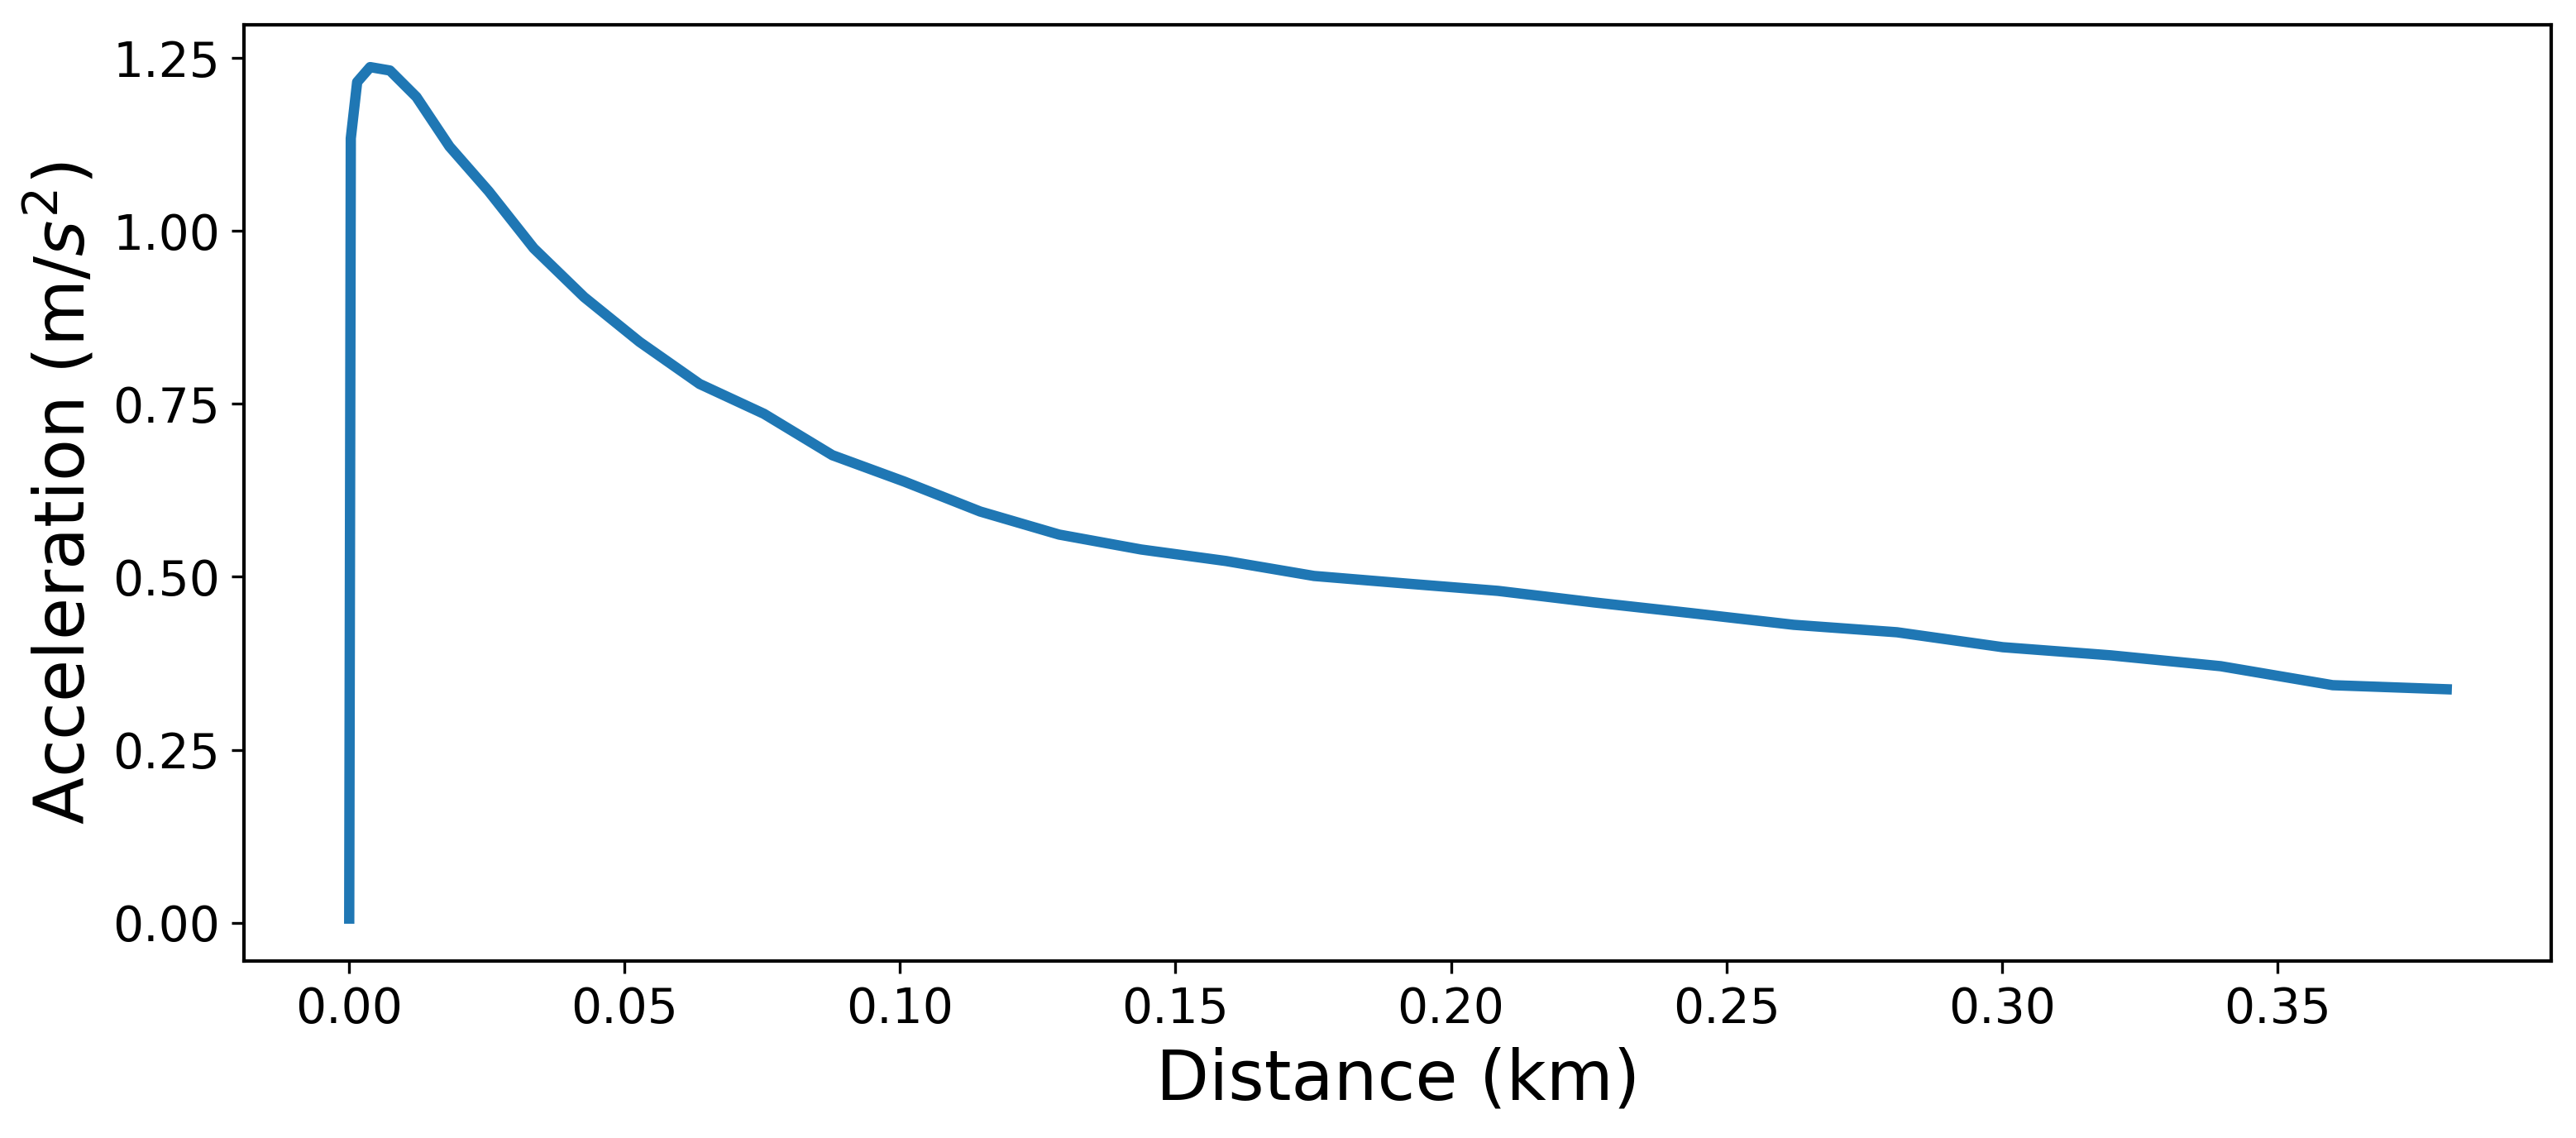

In [12]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(data['dist (km)'], data['accel. (m/s^2)'], linewidth=3)
ax.set_ylabel('Acceleration (m/$s^2$)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.savefig('4_29/accel_vs_dist.png', dpi=300)

In [13]:
#Create new dataframe where dist. is the indep var

data2 = pd.DataFrame({'dist. (ft)': np.arange(0, 1260, 36)})
data2['dist. (m)'] = data2['dist. (ft)']/3.281

data2['vel. (m/s)'] = np.zeros(len(data2.index))

data2['vel. (km/hr)'] = np.zeros(len(data2.index))

data2['vel. (mph)'] = np.zeros(len(data2.index))

data2['accel. (m/s^2)'] = np.zeros(len(data2.index))

data2['delta_time (s)'] = np.zeros(len(data2.index))

data2['time (s)'] = np.zeros(len(data2.index))

In [14]:
for i in range(1, len(data2)):

    z = data2['dist. (ft)'].iloc[i]
    params = data.iloc[(data['dist (ft)']-z).abs().argsort()[:1]]
    row = params.index.values


    #Interpolate
    if params['dist (ft)'].values < z:
        vel = ((data['vel. (m/s)'][row+1].values - data['vel. (m/s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['vel. (m/s)'][row].values
        accel = ((data['accel. (m/s^2)'][row+1].values - data['accel. (m/s^2)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['accel. (m/s^2)'][row].values
        delta_time = ((data['time (s)'][row+1].values - data['time (s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values))
        time = delta_time + data['time (s)'][row].values
    else:
        vel = ((data['vel. (m/s)'][row].values - data['vel. (m/s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['vel. (m/s)'][row-1].values
        accel = ((data['accel. (m/s^2)'][row].values - data['accel. (m/s^2)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['accel. (m/s^2)'][row-1].values
        delta_time = ((data['time (s)'][row].values - data['time (s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) 
        time = delta_time + data['time (s)'][row-1].values
    
    data2['vel. (m/s)'].iloc[i] = vel
    data2['vel. (km/hr)'].iloc[i] = vel*3.6
    data2['vel. (mph)'].iloc[i] = vel*2.2
    data2['accel. (m/s^2)'].iloc[i] = accel
    data2['delta_time (s)'].iloc[i] = delta_time
    data2['time (s)'].iloc[i] = time

In [15]:
data2.head()

,dist. (ft),dist. (m),vel. (m/s),vel. (km/hr),vel. (mph),accel. (m/s^2),delta_time (s),time (s)
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,36,10.972265,5.109799,18.395277,11.241558,1.203615,0.745464,4.745464
2,72,21.944529,7.151014,25.743649,15.732230,1.088142,0.527016,6.527016
3,108,32.916794,8.612282,31.004216,18.947021,0.980834,0.930584,7.930584
4,144,43.889058,9.731477,35.033317,21.409250,0.896401,0.124810,9.124810


In [16]:
data2['dist. (m)'].iloc[-1]

373.0569948186528

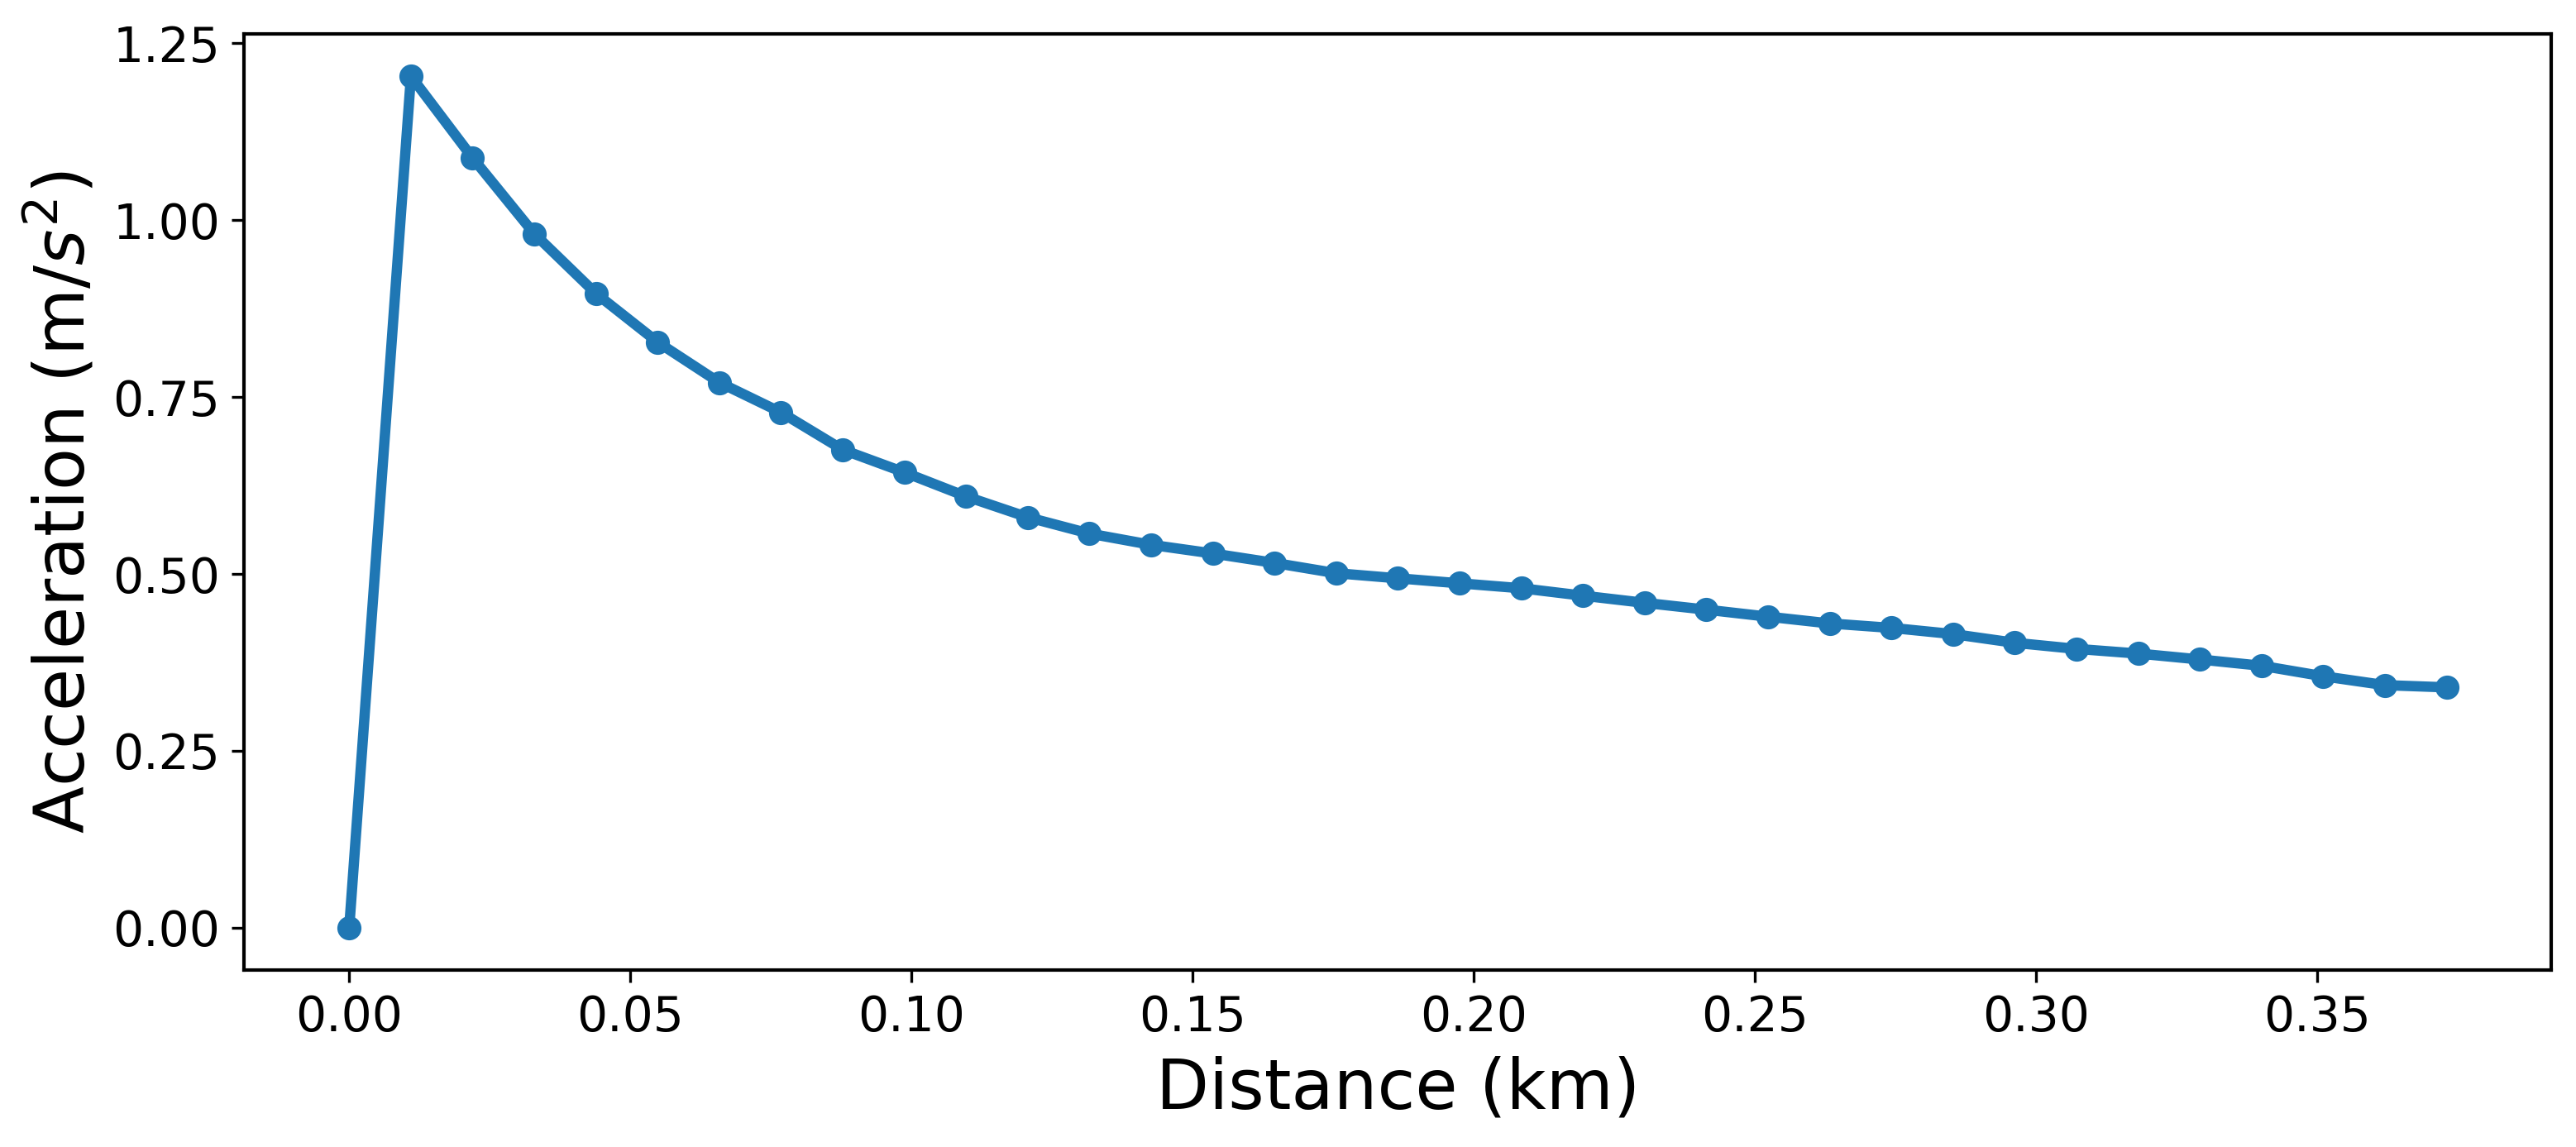

In [17]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(data2['dist. (m)']/1000, data2['accel. (m/s^2)'], linewidth=3, marker = 'o')
ax.set_ylabel('Acceleration (m/$s^2$)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.savefig('4_29/accel_vs_dist2.png', dpi=300)

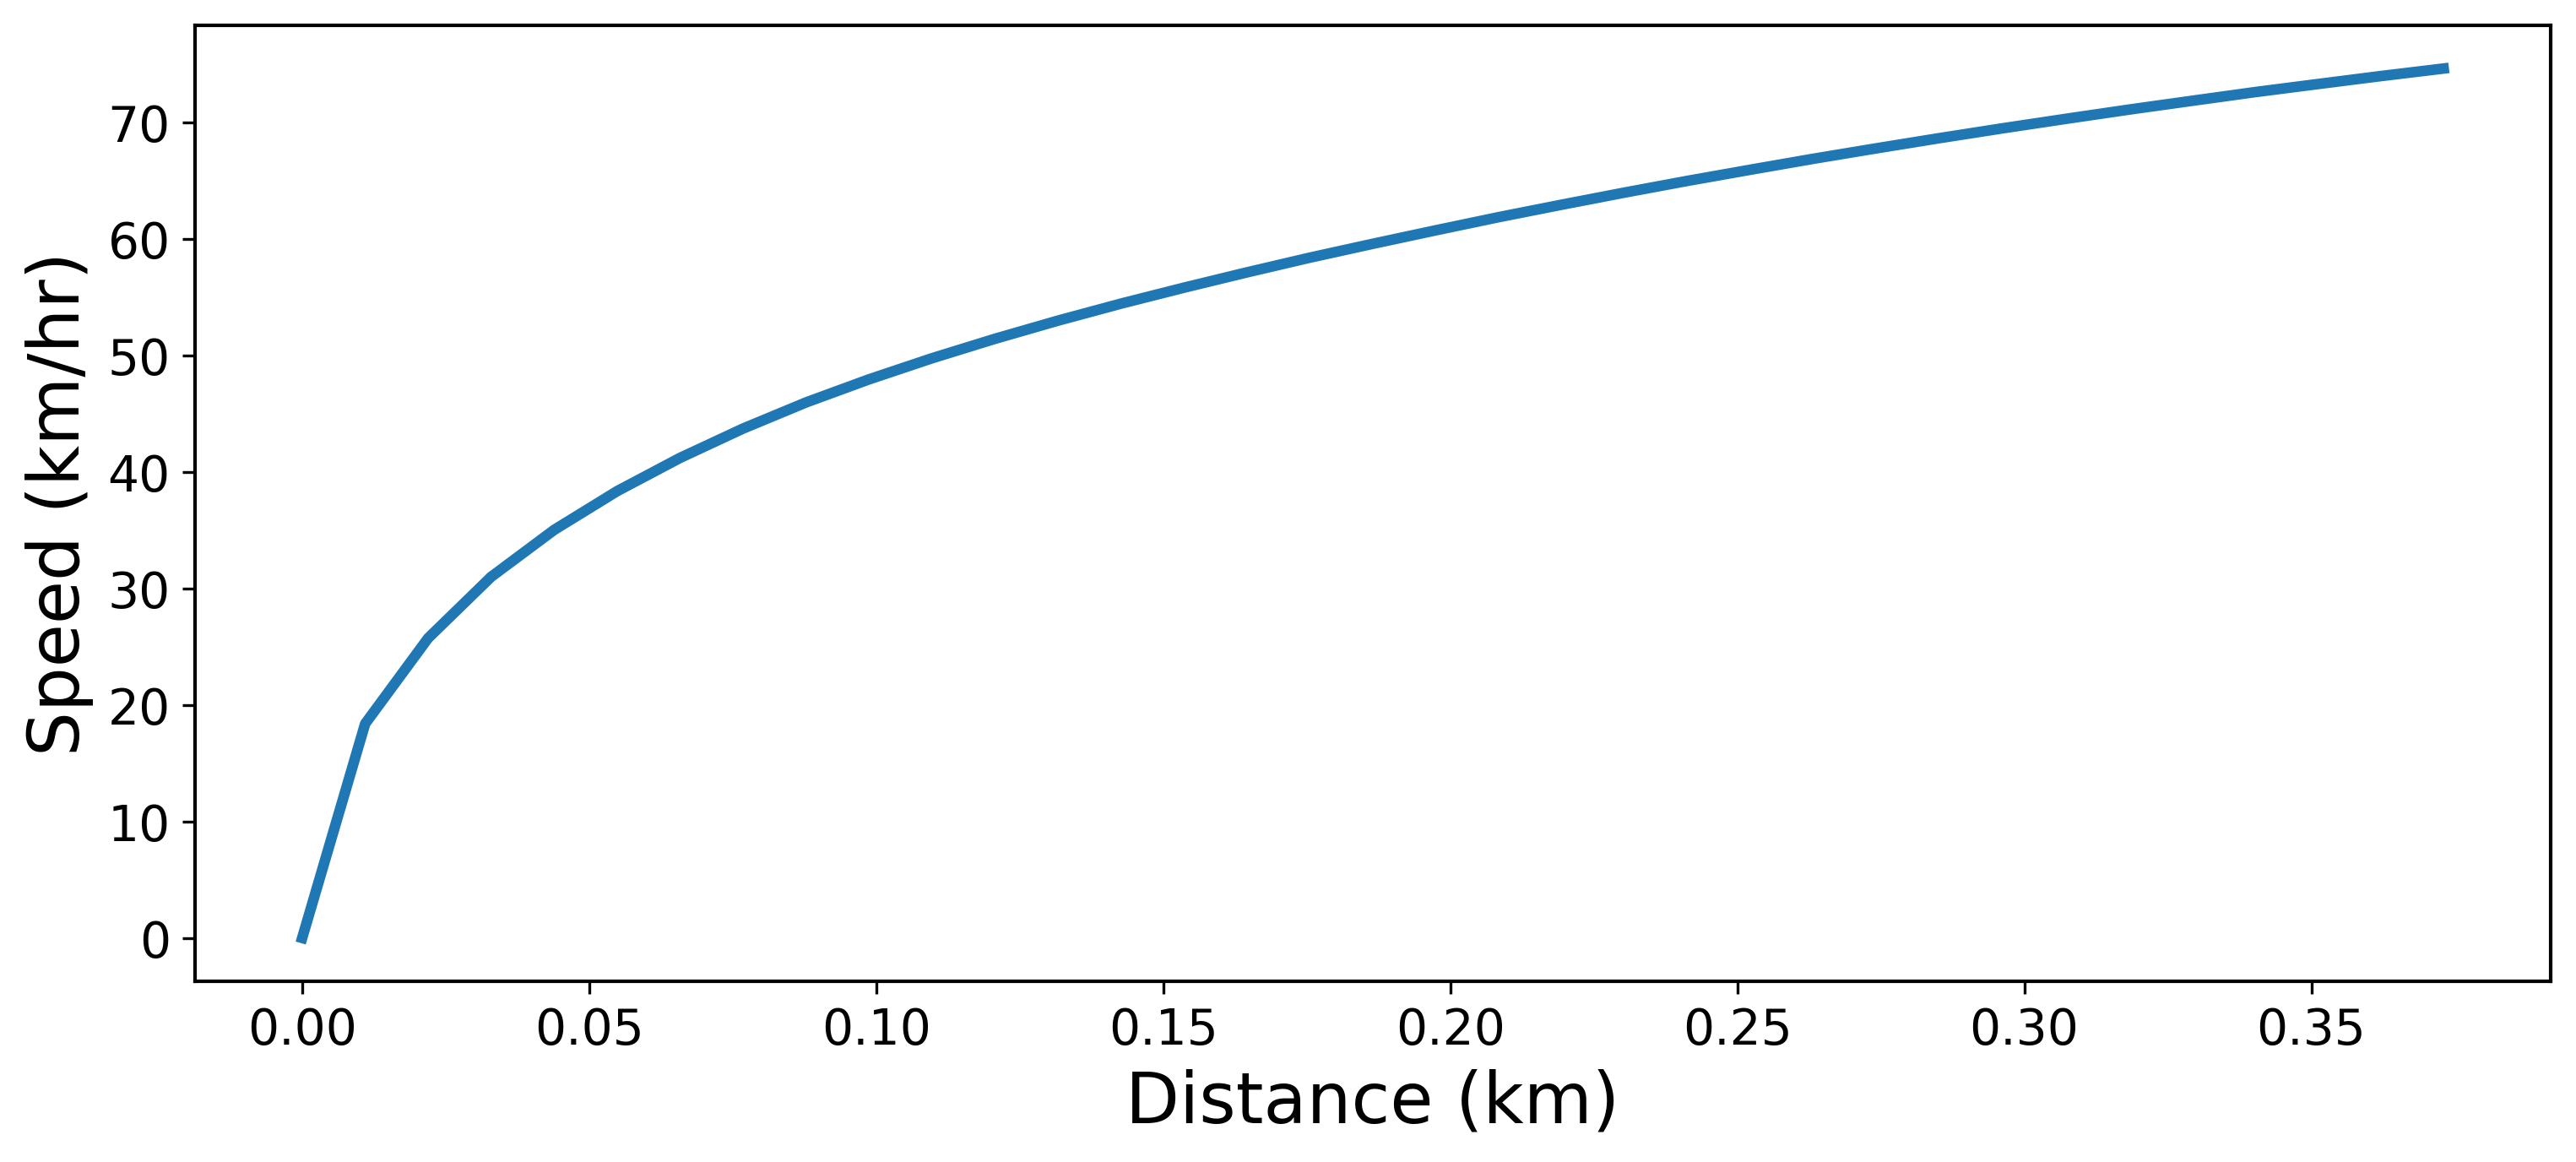

In [18]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(data2['dist. (m)']/1000, data2['vel. (km/hr)'], linewidth=3)
ax.set_ylabel('Speed (km/hr)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
#ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.rcParams["axes.linewidth"] = 3
plt.savefig('4_29/vel_vs_dist.png', dpi=300)

In [19]:
air_density = 1.2
v_wind = 0.0 # wind speed in km per hour; figure out component,
    # and also will come from weather API
fric_coeff = 0.01
width = 2.6 # in m
height = 3.3 # in m
bus_front_area = width * height
drag_coeff = 0.6 # drag coefficient estimate from paper (???)
rw = 0.5 # radius of wheel in m
loaded_bus_mass = 13041
gravi_accel = 9.81


In [20]:
# Calculate the gravitational force
grav_force = 0

# Calculate the rolling friction
roll_fric = -(
    fric_coeff * loaded_bus_mass * gravi_accel * np.cos(0)
    )

# Calculate the aerodynamic drag
aero_drag = -(
    drag_coeff
    *
    bus_front_area
    *
    (air_density/2)
    *
    (data2['vel. (m/s)']-v_wind)**2
    )

# Calculate the inertial force
inertia = loaded_bus_mass * data2['accel. (m/s^2)']

In [21]:
f_resist = (
    grav_force
    +
    roll_fric
    +
    aero_drag
    )

f_traction = inertia - f_resist

velocity = data2['vel. (m/s)'].values

p_traction = f_traction * velocity


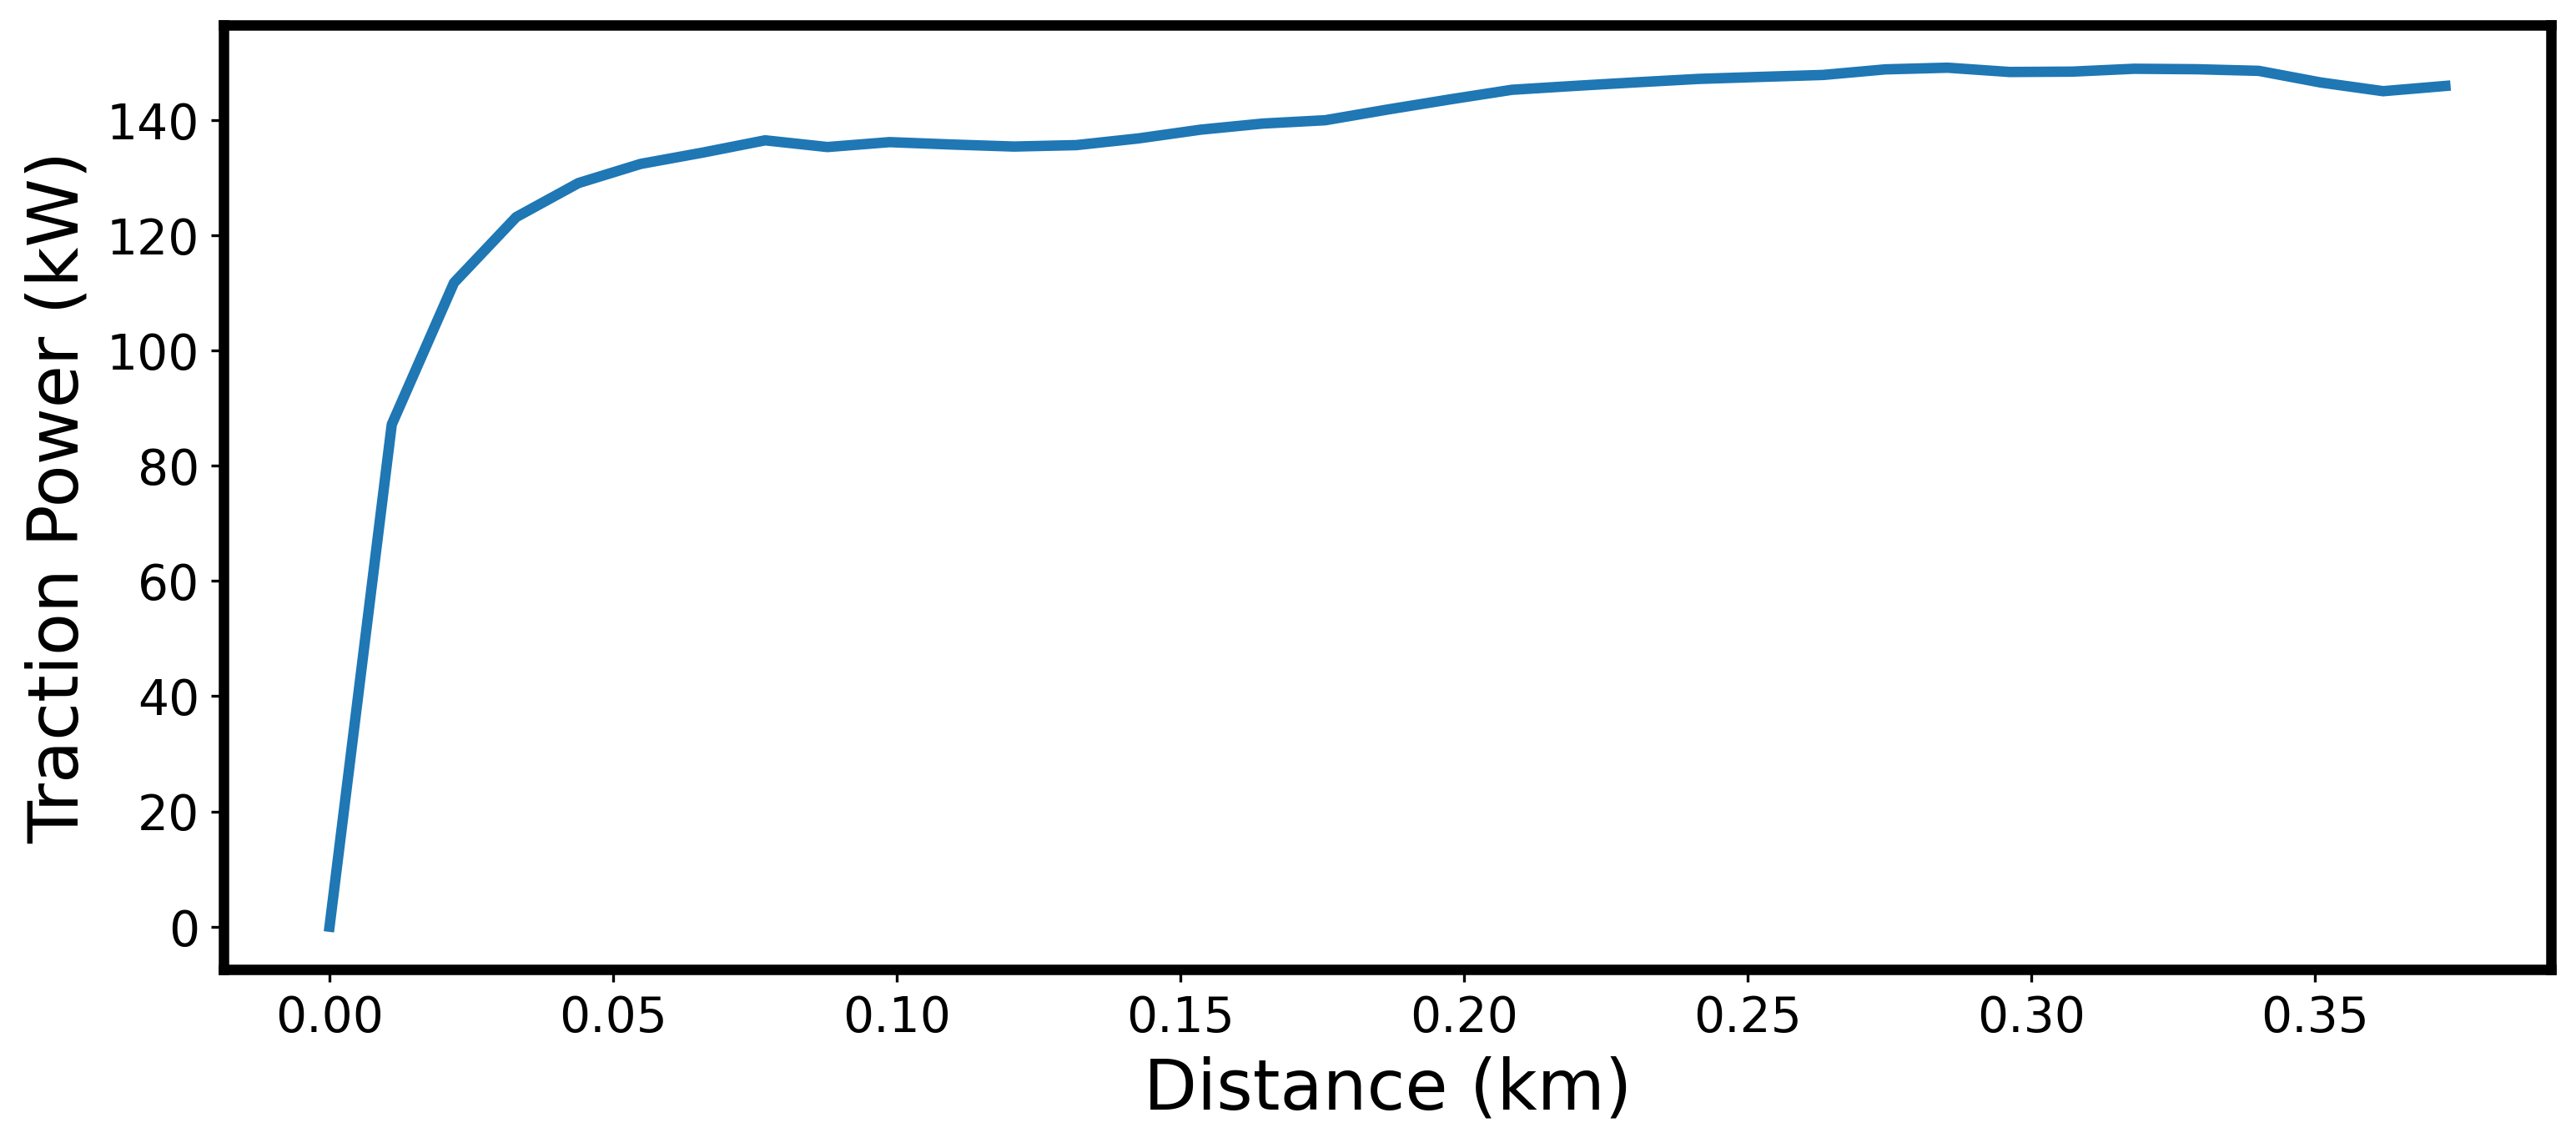

In [22]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(data2['dist. (m)']/1000, p_traction/1000, linewidth=3)
ax.set_ylabel('Traction Power (kW)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
#ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.rcParams["axes.linewidth"] = 1
plt.savefig('4_29/power_vs_dist.png', dpi=300)

In [23]:
distance = np.arange(0, 1000, 10.972265)

In [24]:
speed_limit = np.full(len(distance), 11.175682)

In [25]:
is_stop = ([False] * len(distance))
is_bus_stop = ([False] * len(distance))
is_signal = ([False] * len(distance))

In [26]:
is_stop[10] = True
is_bus_stop[10] = True
#is_stop


In [27]:
d = {'distance': distance, 'speed_limit': speed_limit,
     'is_bus_stop': is_bus_stop, 'is_signal': is_signal, 
     'is_stop': is_stop}

In [28]:
route_df = pd.DataFrame(d)

In [29]:
route_df

,distance,speed_limit,is_bus_stop,is_signal,is_stop
0,0.000000,11.175682,False,False,False
1,10.972265,11.175682,False,False,False
2,21.944530,11.175682,False,False,False
3,32.916795,11.175682,False,False,False
4,43.889060,11.175682,False,False,False
...,...,...,...,...,...
87,954.587055,11.175682,False,False,False
88,965.559320,11.175682,False,False,False
89,976.531585,11.175682,False,False,False
90,987.503850,11.175682,False,False,False


In [30]:
a_pos = 0.4
a_neg = -1.5

x_p = data2['dist. (m)'].iloc[-1]

x_ns = np.zeros(len(route_df.index)) #next stops
x_ls = np.zeros(len(route_df.index)) # prev. stops

abs(route_df['speed_limit'].iloc[i]**2. / (2*a_neg))

41.631956055041336

In [31]:
for i in range(len(x_ns)):
    # set values to Nan if bus stop
    if route_df.at[i, 'is_stop']:
        x_ns[i] = 0.
        x_ls[i] = 0.
        # move to next point
        continue
    else:
        # Calculate 'x_ns';
        # Iterate through remaining indicies to count distance to
        # next stop.
        for j in range(i+1, len(x_ns)):
            # add distance to next point to 'x_ns'
            x_ns[i] += 10.972265
            if route_df.at[j, 'is_stop']:
                break # done calulating 'x_ns' at this point
            # elif not bus stop: move to next point, add distance

        # Calculate 'x_ls';
        # Iterate through previous indicies to cout distance to
        # last stop.
        for j in range(i, 0, -1):
            # Inclusive start to range because distances are
            # backward difference. Dont need to include 'j=0'
            # because the first point has no backward difference.
            if route_df.at[j, 'is_stop']:
                break # done calulating x_ls at this point
            x_ls[i] += 10.972265 

In [32]:
v = np.zeros(len(route_df)) #array for vel.
a = np.zeros(len(route_df)) #array for accel.

In [33]:
count = 0

In [34]:
for i in range(len(x_ns)):
    x_d = route_df['speed_limit'].iloc[i]**2. / (2*a_neg)
    v_lim = route_df['speed_limit'].iloc[i]

    if count > i:
        continue

    else:

        #Case 1

        if (
            x_ns[i]<=abs(x_d)
            and
            not route_df.at[i, 'is_stop']
            ):

            a[i] = a_neg
            v[i] = np.sqrt(-2*x_ns[i]*a_neg)
            count += 1

        #Case 2

        elif (
            x_ns[i] > abs(x_d)
            and
            x_ls[i] >= x_p
            and
            not route_df.at[i, 'is_stop']
            ):

            if v[i-1] < v_lim:

                a[i] = a_pos
                v[i] = np.sqrt(2*x_ns[i]*a[i])
                count += 1

            elif v[i-1]>v_lim:

                while x_ns[count]>abs(x_d):

                    a[count] = 0
                    v[count] = v_lim

                    count+=1

                else:
                    continue 

            else:
                continue



        #Case 3

        elif (
            x_ls[i] < x_p
            and
            x_ns[i] > abs(x_d)
            and
            not route_df.at[i, 'is_stop']
            ):

            for j in range(len(data2)):

                if count < len(x_ns):

                    if v[count-1] < v_lim:
                        a[count] = data2['accel. (m/s^2)'].iloc[j]
                        v[count] = data2['vel. (m/s)'].iloc[j]
                        count+=1



                    elif v[count-1]>v_lim:

                        while x_ns[count]>abs(x_d):

                            a[count] = 0
                            v[count] = v_lim

                            count+=1

                        else:
                            break

                    else:
                        continue

                else:
                    break


        elif route_df.at[i, 'is_stop']:

            count += 1

back_diff_delta_x = np.full(len(route_df), 10.9728)


segment_avg_velocities = (
                v
                +
                np.append(0,v[:-1])
                )/2

delta_times = back_diff_delta_x / segment_avg_velocities
delta_times[delta_times > 1000000] = 0

for i in range(len(route_df)):
    if route_df.at[i, 'is_bus_stop']:
        delta_times[i]+=30 #make variable later

    elif route_df.at[i, 'is_signal']:
        delta_times[i]+=30 #make variable later
    else:
        pass

time_on_route = np.append(0, np.cumsum(delta_times[1:]))

t = time_on_route

In [35]:
a

array([ 0.        ,  1.20361531,  1.08814184,  0.98083416,  0.89640104,
        0.82761361,  0.77060627, -1.5       , -1.5       , -1.5       ,
        0.        ,  0.        ,  1.20361531,  1.08814184,  0.98083416,
        0.89640104,  0.82761361,  0.77060627,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

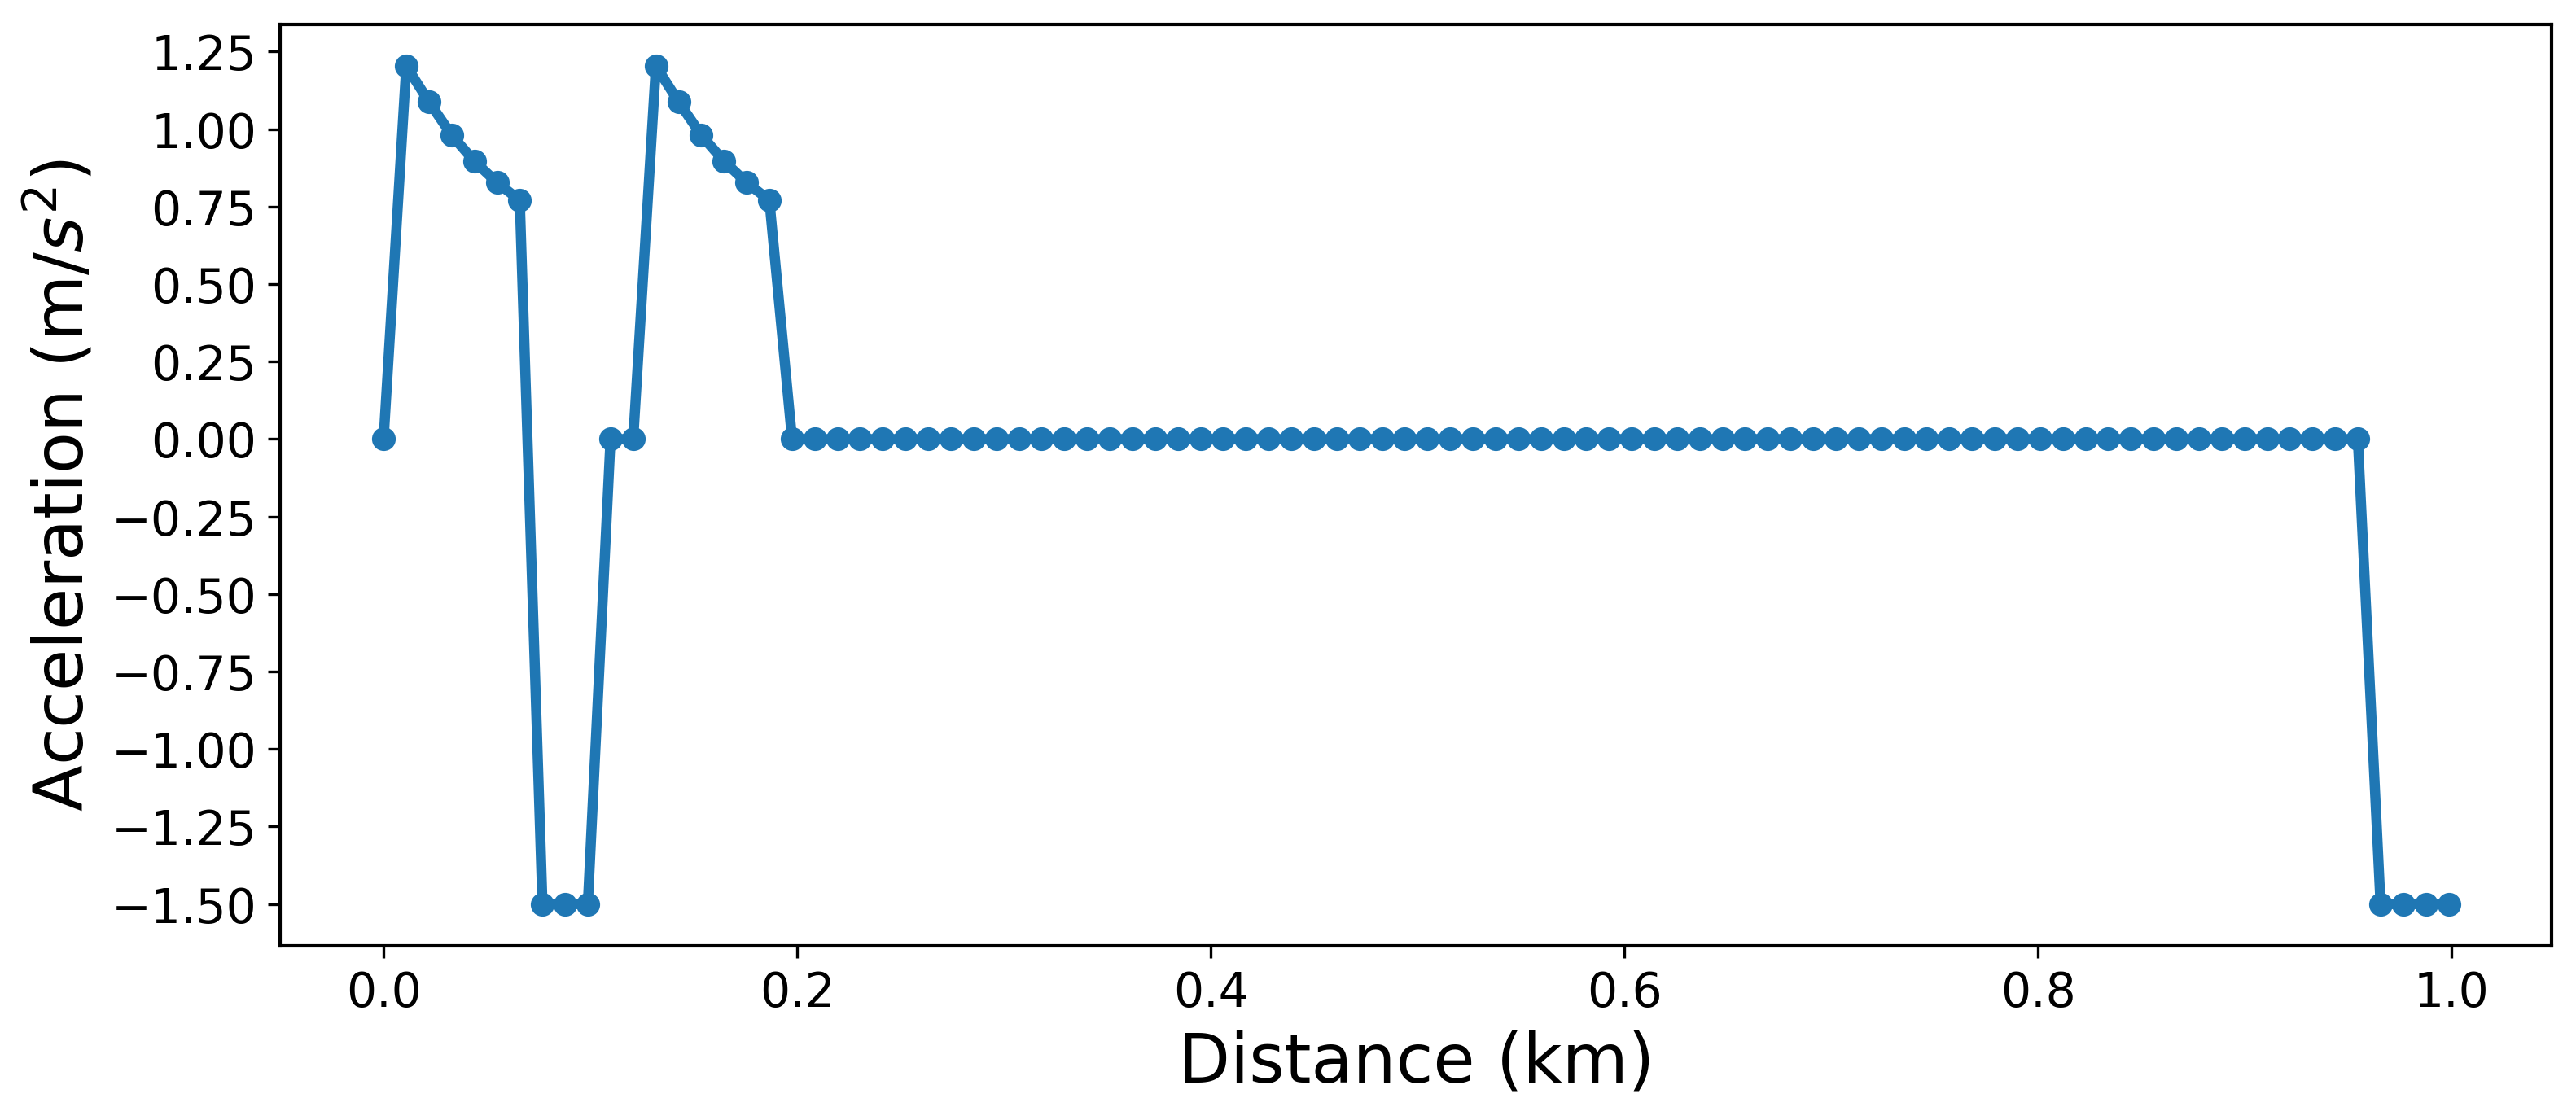

In [36]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(distance/1000, a, linewidth=3, marker = 'o')
ax.set_ylabel('Acceleration (m/$s^2$)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_yticks(np.arange(-1.5, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.savefig('4_29/accel_vs_dist_ex.png', dpi=300)

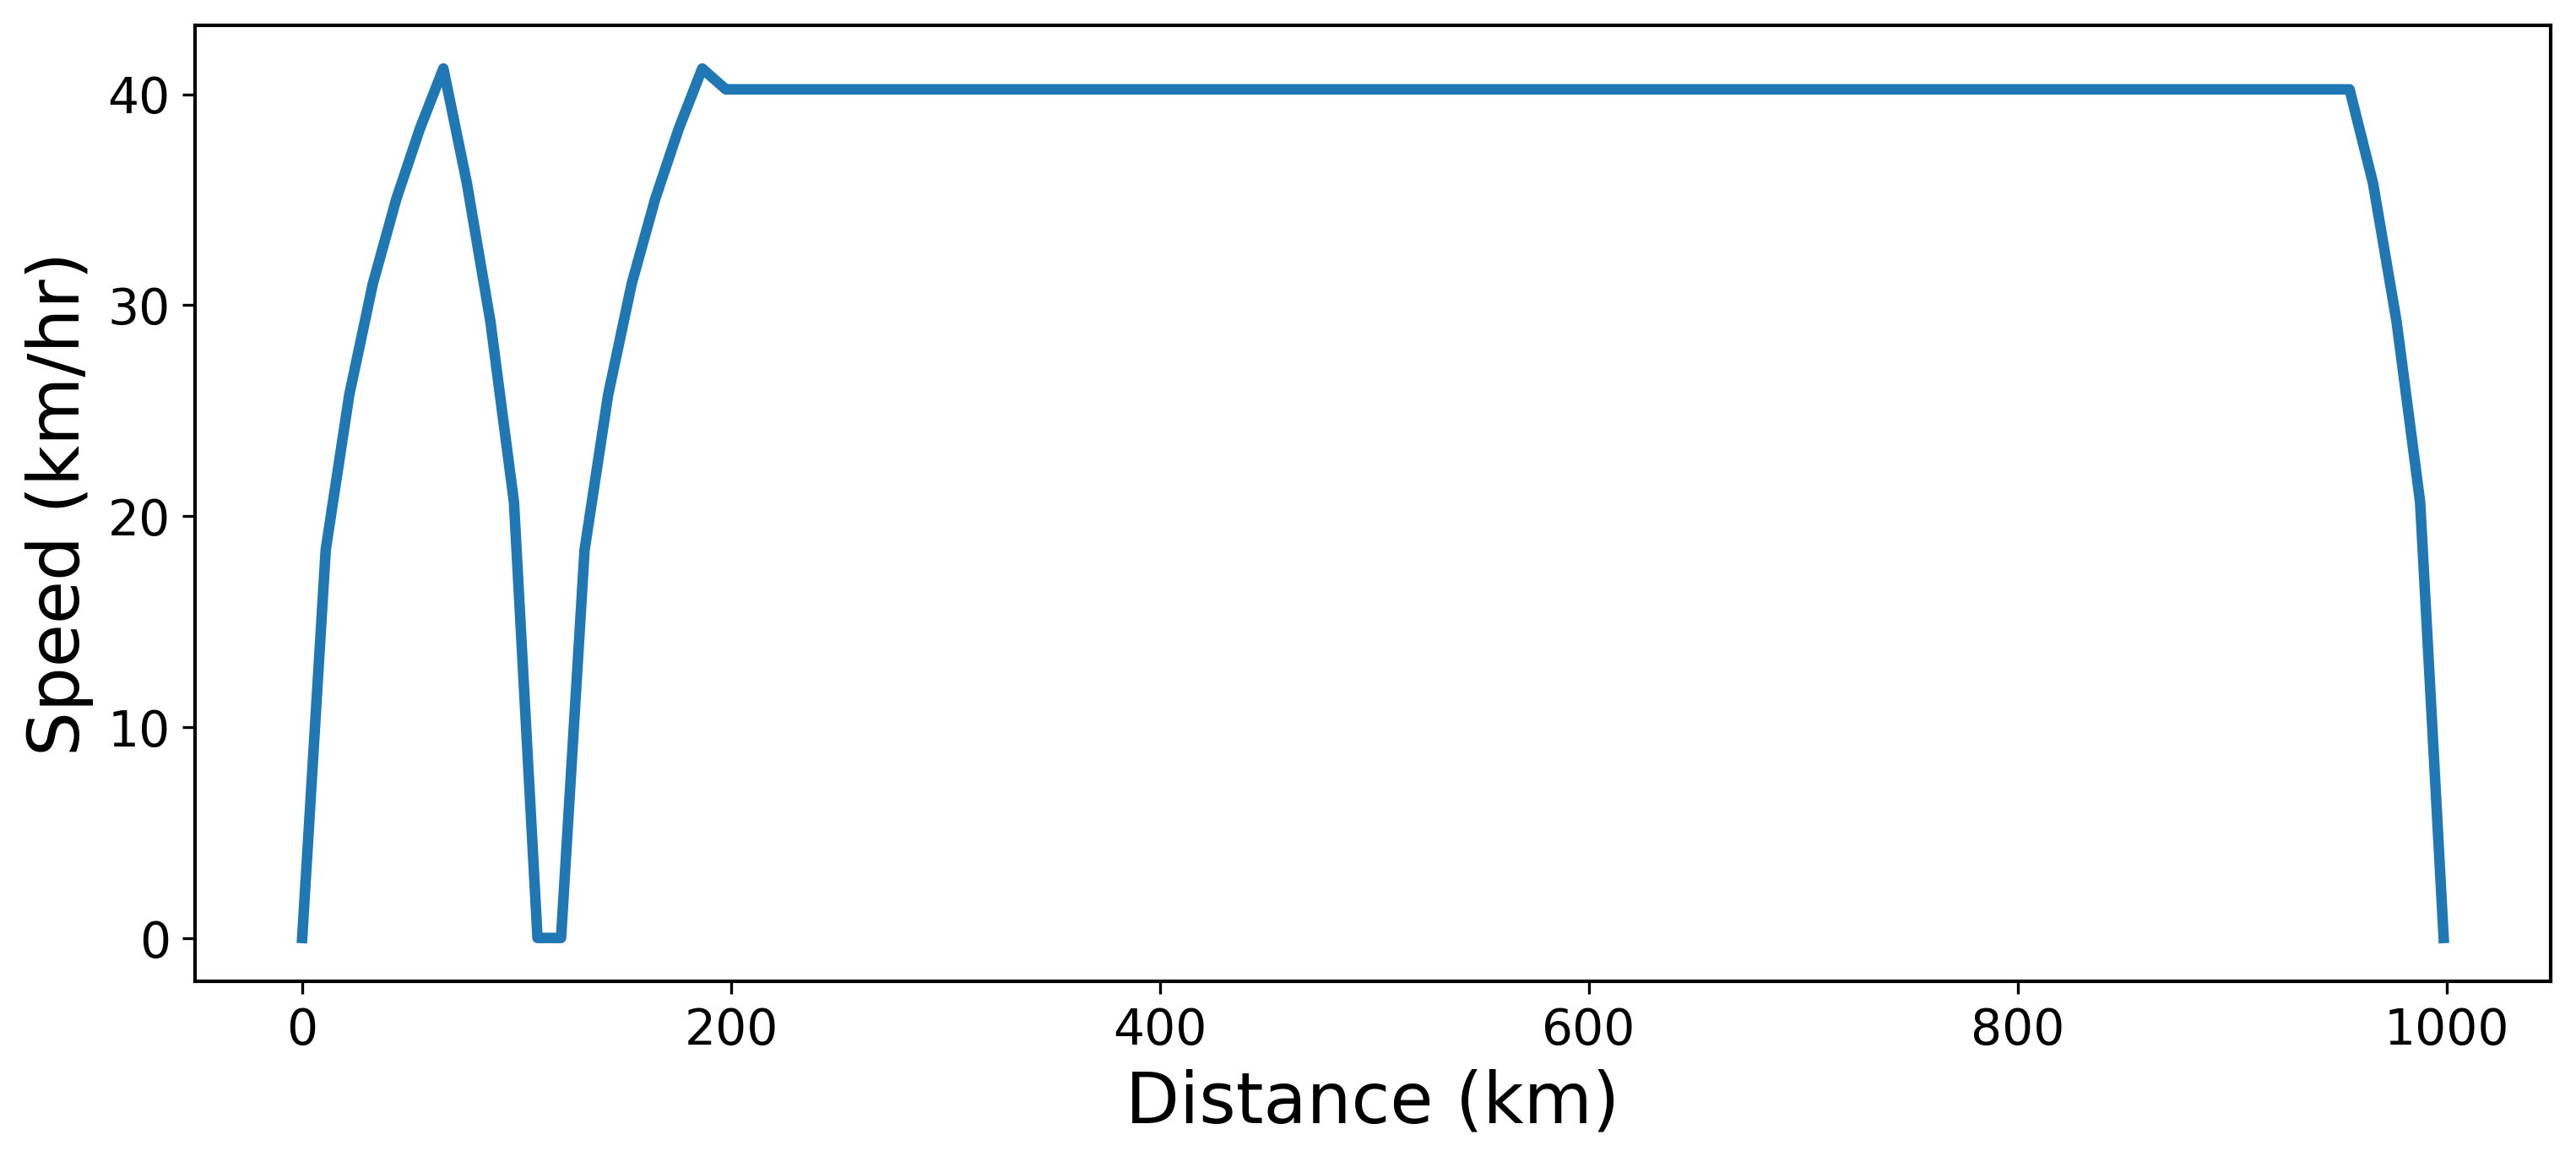

In [37]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(distance, v*3.6, linewidth=3)
ax.set_ylabel('Speed (km/hr)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
#ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.rcParams["axes.linewidth"] = 3
plt.savefig('4_29/vel_vs_dist_ex.png', dpi=300)

In [38]:
distance = np.arange(0, 500, 10.972265)

In [39]:
speed_limit = np.full(len(distance), 11.175682)

In [40]:
is_stop = ([False] * len(distance))
is_bus_stop = ([False] * len(distance))
is_signal = ([False] * len(distance))

In [41]:
is_stop[9] = True
is_bus_stop[9] = True


In [42]:
is_bus_stop[-1]

False

In [43]:
d = {'distance': distance, 'speed_limit': speed_limit,
     'is_bus_stop': is_bus_stop, 'is_signal': is_signal, 
     'is_stop': is_stop}

In [44]:
route_df = pd.DataFrame(d)

In [45]:
route_df.head(11)

,distance,speed_limit,is_bus_stop,is_signal,is_stop
0,0.000000,11.175682,False,False,False
1,10.972265,11.175682,False,False,False
2,21.944530,11.175682,False,False,False
3,32.916795,11.175682,False,False,False
4,43.889060,11.175682,False,False,False
5,54.861325,11.175682,False,False,False
6,65.833590,11.175682,False,False,False
7,76.805855,11.175682,False,False,False
8,87.778120,11.175682,False,False,False
9,98.750385,11.175682,True,False,True


In [47]:
a_pos = 0.4
a_neg = -1.5

(accelerations,
velocities,
x_ls,
x_ns,
delta_times
) = ca.accel_dynamics(
route_df,
a_prof,
a_pos,
a_neg
)

In [48]:
print(x_ns)
print(velocities)
print(x_ls)
print(accelerations)

[ 98.750385  87.77812   76.805855  65.83359   54.861325  43.88906
  32.916795  21.94453   10.972265   0.       384.029275 373.05701
 362.084745 351.11248  340.140215 329.16795  318.195685 307.22342
 296.251155 285.27889  274.306625 263.33436  252.362095 241.38983
 230.417565 219.4453   208.473035 197.50077  186.528505 175.55624
 164.583975 153.61171  142.639445 131.66718  120.694915 109.72265
  98.750385  87.77812   76.805855  65.83359   54.861325  43.88906
  32.916795  21.94453   10.972265   0.      ]
[ 0.          5.10979918  7.15101368  8.61228233  9.73147707 10.65604403
  9.93732283  8.11379011  5.73731601  0.          0.          5.10979918
  7.15101368  8.61228233  9.73147707 10.65604403 11.44982583 11.175682
 11.175682   11.175682   11.175682   11.175682   11.175682   11.175682
 11.175682   11.175682   11.175682   11.175682   11.175682   11.175682
 11.175682   11.175682   11.175682   11.175682   11.175682   11.175682
 11.175682   11.175682   11.175682   11.175682   11.175682   1

In [49]:
x_ns[2]

76.80585500000001

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(distance/1000, accelerations, linewidth=3)
ax.set_ylabel('Acceleration (m/$s^2$)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_yticks(np.arange(-1.5, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.savefig('4_29/accel_vs_dist_ex.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(distance/1000, velocities*3.6, linewidth=3)
ax.set_ylabel('Speed (km/hr)', fontsize=20)
ax.set_xlabel('Distance (km)', fontsize=20)
#ax.set_yticks(np.arange(0, 1.5, 0.25))

ax.tick_params(labelsize=14)

plt.rcParams["axes.linewidth"] = 3
plt.savefig('4_29/vel_vs_dist_ex.png', dpi=300)